<center><h1>Best Toronto Neighborhoods to open an Persian Restaurant.</h1></center>

<h3>Prospects of a opening an Indian Restaurant in Toronto, Canada.</h3>


<h2>Data acquisition and cleaning</h2>


<h3>Data Sources</h3>


a) WikiPedia : https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M 
b) Cocl:  “https://cocl.us/Geospatial_data” 
c) Demographics of Toronto: https://en.m.wikipedia.org/wiki/Demographics_of_Toronto#Ethnic_diversity 
d) Foursquare API: https://developer.foursquare.com/docs \
Data reetrived from API for each venue:
<li>Name: The name of the venue. </li>
<li>Category: The category type as defined by the API.</li>
<li>Latitude: The latitude value of the venue.</li>
<li>Longitude: The longitude value of the venue.</li>


<h3>Data Cleaning</h3>

<h4>Scraping Toronto Neighborhoods Table from Wikipedia</h4>

#### Scraped the following Wikipedia page, “List of Postal code of Canada: M” in order to obtain the data about the Toronto & the Neighborhoods in it.
wikipedia - package is used to scrape the data from wiki.

In [1]:
# importing the libraries
import pandas as pd
import numpy as np

# wikipedia library for pyton
import wikipedia as wp

# Send and Receiveing the data

import io
import requests
import wikipedia as wp

# ploting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from geopy.geocoders import Nominatim
import folium 

# Modleing 
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# hidding the warnings
import warnings
warnings.filterwarnings("ignore")

/Users/arash/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#Getting data from wikipedia
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
df = pd.read_html(html, header = 0)[0]
df = pd.DataFrame(df)
df

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
...,...,...,...
175,M5Z,Not assigned,NaN
176,M6Z,Not assigned,NaN
177,M7Z,Not assigned,NaN
178,M8Z,Etobicoke,Mimico NW / The Queensway West / South of Bloo...


In [3]:
#Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
df = df[df.Borough != 'Not assigned']
df.rename(columns={'Postal code': 'PostalCode'}, inplace=True)

In [4]:
#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. 
#So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.
for index, row in df.iterrows():
    if row['Neighborhood'] == 'Not assigned':
        row['Neighborhood'] = row['Borough']


df.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [5]:
# Grouping the DataFrame by postal codes
df = df.groupby(['Borough', 'PostalCode'])['Neighborhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()
df.head()

,Borough,PostalCode,Neighborhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,North Toronto West
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,Moore Park / Summerhill East


<h4>Adding geographical coordinates to the neighborhoods</h4>

Next important step is adding the geographical coordinates to these neighborhoods. To do so I'm extracting the data present in the Geospatial Data csv file and I'm combining it with the existing neighborhood dataframe by merging them both based on the postal code.  

In [6]:
#Reading the latitude & longitude data from CSV file

url = "https://cocl.us/Geospatial_data"
lat_long = requests.get(url).text
lat_long_df=pd.read_csv(io.StringIO(lat_long))
lat_long_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


I'm renaming the columns to match the existing dataframe  

In [7]:
lat_long_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
lat_long_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


After that I'm merging both the dataframe into one by matching on the postal code. 

In [8]:
toronto_DF = pd.merge(df,lat_long_df, on='PostalCode')
toronto_DF.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)
toronto_DF.head()

,Borough,PostalCode,Neighborhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,Moore Park / Summerhill East,43.689574,-79.383160


In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_DF['Borough'].unique()),
        toronto_DF.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


<h4>Scrap the distribution of population from Wikipedia</h4>

Another factor that can help us in deciding which neighborhood would be best option to open a restaurant is, the distribution of population based on the ethnic diversity for each neighborhood. As this helps us in identifying the neighborhoods which are densely populated with Indian crowd since that neighborhood would be an ideal place to open an Indian restaurant. 

Scraped the following Wikipedia page, “Demographics of Toronto” in order to obtain the data about the Toronto & the Neighborhoods in it. Compared to all the neighborhoods in Toronto below given neighborhoods only had considerable amount of Persian crowd. We are examing those neighborhood's population to identify the densely populated neighborhoods with Persian population.

In [10]:
#overall population distribution 
html = wp.page("Demographics of Toronto").html().encode("UTF-8")


In [11]:
#TORONTO & EAST YORK population distribution by ethnicity 
TEY_population_df = pd.read_html(html, header = 0)[13]
TEY_population_df = TEY_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %',
                                                     '%.8':'Ethnic Origin 9 in %'})
TEY_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.5,Irish,9.2,Russian,8.4
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN
6,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.0,Filipino,7.8,NaN,NaN


In [12]:
#NORTH YORK population distribution by ethnicity 
North_population_df = pd.read_html(html, header = 0)[14]
North_population_df = North_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
North_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN
1,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN
2,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0
4,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN
5,Scarborough North,97610,Chinese,46.6,East Indian,11.8,Sri Lankan,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#SCARBOROUGH population distribution by ethnicity 
Scar_population_df = pd.read_html(html, header = 0)[15]
Scar_population_df = Scar_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
Scar_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Etobicoke-Lakeshore,127520,English,17.1,Canadian,15.9,Irish,14.4,Scottish,13.5,Polish,9.2,Italian,9.1,Ukrainian,7.6,German,7.1
1,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Etobicoke Centre,116055,Italian,15.1,English,14.3,Canadian,12.1,Irish,10.8,Scottish,10.4,Ukrainian,8.1,Polish,7.4,NaN,NaN
3,York South-Weston,115130,Portuguese,14.5,Italian,12.8,Canadian,8.7,Jamaican,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#ETOBICOKE & YORK population distribution by ethnicity 
ETY_population_df = pd.read_html(html, header = 0)[16]
ETY_population_df = ETY_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
ETY_population_df

,"Ethnic groups in the Toronto CMA (2016)Source: Focus on Geography Series, 2016 Census; Toronto, (CMA) - Ontario","Ethnic groups in the Toronto CMA (2016)Source: Focus on Geography Series, 2016 Census; Toronto, (CMA) - Ontario.1",Population,Ethnic Origin 1 in %
0,Ethnic group,White,2804630,47.8
1,Ethnic group,South Asian,973225,16.6
2,Ethnic group,Chinese,631045,10.8
3,Ethnic group,Black,442020,7.5
4,Ethnic group,Filipino,254480,4.3
5,Ethnic group,Latin American,132950,2.3
6,Ethnic group,West Asian,123755,2.1
7,Ethnic group,Arab,105610,1.8
8,Ethnic group,Southeast Asian,83540,1.4
9,Ethnic group,Korean,69670,1.2


<h4>Get location data using Foursquare</h4>

Foursquare API is very usefule online application used my many developers & other application like Uber etc. In this project I have used it to retrieve informtion about the places present in the neighborhoods of Toronto. The API returns a JSON file and we need to turn that into a data-frame. Here I’ve chosen 100 popular spots for each neighborhood within a radius of 1km. 



In [15]:
#Use geopy library to get the latitude and longitude values of New York City.

address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [16]:
CLIENT_ID = 'L5UWTDB4CBKBOUQ54K3FEUC4MFIYJBBQZ4LMZSWKOAYSV5X4'
CLIENT_SECRET = '0UYLJLZJR55L5EUS4BI4NII4K4QLYD4SYJ0OLO0INGN4DCQ1'
VERSION = '20180604'

In [17]:
# map rendering library
radius=1000
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius)
results = requests.get(url).json()


In [18]:
#Function to get the category

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Using the get_category_type function, we clean up the json and turn it into a pandas dataframe. Before we start that we need to import certain libraries.

In [19]:
import json
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,Plaza,43.652270,-79.383516
2,Indigo,Bookstore,43.653515,-79.380696
3,Eggspectation Bell Trinity Square,Breakfast Spot,43.653144,-79.381980
4,Chatime 日出茶太,Bubble Tea Shop,43.655542,-79.384684


Now we can explore the nearby venues!

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
LIMIT = 100
toronto_venues = getNearbyVenues(names=toronto_DF['Neighborhood'],
                                   latitudes=toronto_DF['Latitude'],
                                   longitudes=toronto_DF['Longitude']
                                  )

Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park / Summerhill East
Summerhill West / Rathnelly / South Hill / Forest Hill SE / Deer Park
Roselawn
Forest Hill North & West
The Annex / North Midtown / Yorkville
Rosedale
St. James Town / Cabbagetown
Church and Wellesley
Regent Park / Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond / Adelaide / King
Harbourfront East / Union Station / Toronto Islands
Toronto Dominion Centre / Design Exchange
Commerce Court / Victoria Hotel
University of Toronto / Harbord
Kensington Market / Chinatown / Grange Park
CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst Quay / South Niagara / Island airport
Stn A PO Boxes
First Canadian Place / Underground city
Christie
Queen's Park / Ontario Provincial Government
The Beaches
The Danforth West / Riverdale
India Bazaar / The Beaches West
Studio District
Business reply mail Processing CentrE
Parkview Hill / Woodbine Gardens

In [22]:
toronto_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,Granite Club,43.733043,-79.381986,Gym / Fitness Center
2,Lawrence Park,43.728020,-79.388790,Tim Hortons,43.727324,-79.379563,Coffee Shop
3,Lawrence Park,43.728020,-79.388790,Glendon Bookstore,43.727024,-79.378976,Bookstore
4,Lawrence Park,43.728020,-79.388790,Glendon Forest,43.727226,-79.378413,Trail
5,Lawrence Park,43.728020,-79.388790,Glendon Rose Garden,43.727334,-79.378222,College Quad
6,Lawrence Park,43.728020,-79.388790,Lunik Co-op,43.727311,-79.377835,Café
7,Lawrence Park,43.728020,-79.388790,Glendon Athletic Club,43.728799,-79.376819,College Gym
8,Davisville North,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park
9,Davisville North,43.712751,-79.390197,Summerhill Market North,43.715499,-79.392881,Food & Drink Shop


In [23]:
toronto_venues.groupby('Neighborhood').count()


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,43,43,43,43,43,43
Alderwood / Long Branch,27,27,27,27,27,27
Bathurst Manor / Wilson Heights / Downsview North,31,31,31,31,31,31
Bayview Village,13,13,13,13,13,13
Bedford Park / Lawrence Manor East,40,40,40,40,40,40
...,...,...,...,...,...,...
Willowdale / Newtonbrook,31,31,31,31,31,31
Woburn,9,9,9,9,9,9
Woodbine Heights,29,29,29,29,29,29


In [24]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))


There are 332 uniques categories.


There are 332 unique categories in which Persian Restaurant is one of them. We will do one hot encoding for getting dummies of venue category. So that we will calculate mean of all venue groupby there neighborhoods.


In [25]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped



,Neighborhood,Zoo,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.023256,0.0,0.0,0.0,0.0,0.000,0.0,0.0
1,Alderwood / Long Branch,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0
2,Bathurst Manor / Wilson Heights / Downsview North,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.032258,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0
4,Bedford Park / Lawrence Manor East,0.0,0.0,0.0,0.0,0.025,0.0,0.0,0.0,0.0,...,0.0,0.025000,0.000000,0.0,0.0,0.0,0.0,0.025,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Willowdale / Newtonbrook,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0
93,Woburn,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0
94,Woodbine Heights,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.034483,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0
95,York Mills / Silver Hills,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0


In [26]:
print (toronto_venues['Venue Category'].value_counts())

Coffee Shop              384
Café                     219
Park                     159
Pizza Place              146
Restaurant               140
                        ... 
Animal Shelter             1
Warehouse Store            1
Ski Chalet                 1
Sri Lankan Restaurant      1
Social Club                1
Name: Venue Category, Length: 332, dtype: int64


<h2>Exploratory Data Analysis</h2>


<h3>Folium Library and Leaflet Map</h3>

Folium is a python library, I'm using it to draw an interactive leaflet map using coordinate data. 


In [27]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_DF['Latitude'], toronto_DF['Longitude'], toronto_DF['Borough'], toronto_DF['Neighborhood']):
    label = '{},{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<h3>Relationship between neighborhood and Indian Restaurant </h3>

First we will extract the Neighborhood and Indian Restaurant column from the above toronto dataframe for further analysis:

In [28]:
toronto_part = toronto_grouped[['Neighborhood', 'Persian Restaurant']]
toronto_part['Neighborhood']=toronto_part['Neighborhood'].str.replace(u" / ",",")
toronto_part

,Neighborhood,Persian Restaurant
0,Agincourt,0.0
1,"Alderwood,Long Branch",0.0
2,"Bathurst Manor,Wilson Heights,Downsview North",0.0
3,Bayview Village,0.0
4,"Bedford Park,Lawrence Manor East",0.0
...,...,...
92,"Willowdale,Newtonbrook",0.0
93,Woburn,0.0
94,Woodbine Heights,0.0
95,"York Mills,Silver Hills",0.0


In [29]:
toronto_merged = pd.merge(toronto_DF, toronto_part, on='Neighborhood')
toronto_merged

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Persian Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.000000
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.000000
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678,0.000000
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,0.000000
4,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.000000
5,Central Toronto,M5P,Forest Hill North & West,43.696948,-79.411307,0.020833
6,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529,0.000000
7,Downtown Toronto,M4Y,Church and Wellesley,43.665860,-79.383160,0.000000
8,Downtown Toronto,M5B,"Garden District, Ryerson",43.657162,-79.378937,0.000000
9,Downtown Toronto,M5C,St. James Town,43.651494,-79.375418,0.000000


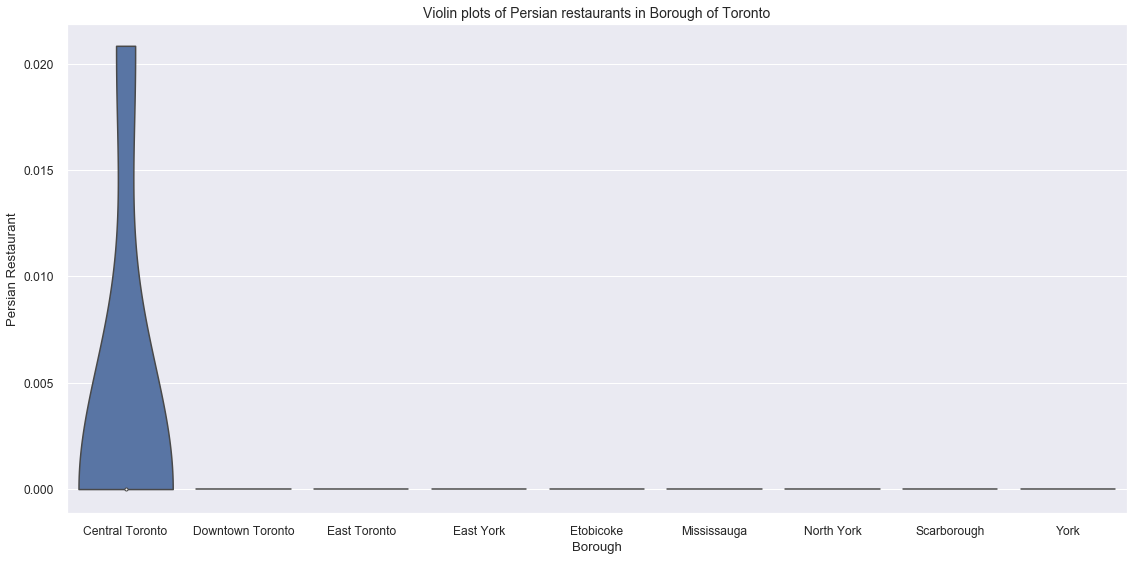

In [30]:
# Let's try Categorical plot 

fig = plt.figure(figsize=(19,9))

sns.set(font_scale=1.1)
sns.violinplot(y="Persian Restaurant", x="Borough", data=toronto_merged, cut=0);

plt.title('Violin plots of Persian restaurants in Borough of Toronto', fontsize=14)
plt.show()

This plot helps in identifying the boroughs with densely populated Persian restaurants.  

Lets visualize the neighborhood with Persian Restaurants

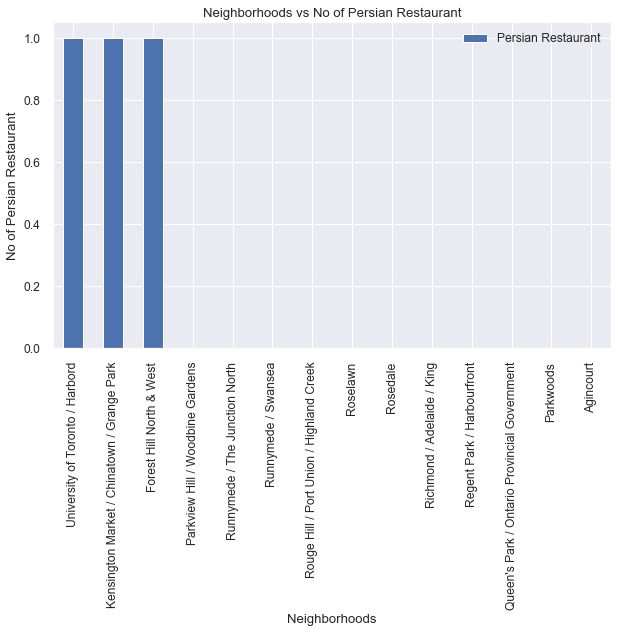

In [31]:
graph = pd.DataFrame(toronto_onehot.groupby('Neighborhood')['Persian Restaurant'].sum())
graph = graph.sort_values(by ='Persian Restaurant', ascending=False)
graph.iloc[:14].plot(kind='bar', figsize=(10,6))
plt.xlabel("Neighborhoods")
plt.ylabel("No of Persian Restaurant")
plt.title("Neighborhoods vs No of Persian Restaurant")
plt.show()

<h3>Relationship between neighborhood and Indian popultion </h3>

In [32]:
#Merge all the population table with the ethnic percentage by neighborhood
ET = ETY_population_df.append(TEY_population_df,sort=True).reset_index()
ET.drop('index',axis=1,inplace=True)
SN = North_population_df.append(Scar_population_df,sort=True).reset_index()
SN.drop('index',axis=1,inplace=True)
pop_ethnic_df = SN.append(ET,sort=True).reset_index()
pop_ethnic_df.drop('index',axis=1,inplace=True)
pop_ethnic_df = pop_ethnic_df[['Riding', 'Population','Ethnic Origin #1', 'Ethnic Origin 1 in %','Ethnic Origin #2', 'Ethnic Origin 2 in %',
                               'Ethnic Origin #3','Ethnic Origin 3 in %','Ethnic Origin #4', 'Ethnic Origin 4 in %','Ethnic Origin #5','Ethnic Origin 5 in %', 
                               'Ethnic Origin #6','Ethnic Origin 6 in %','Ethnic Origin #7', 'Ethnic Origin 7 in %','Ethnic Origin #8', 'Ethnic Origin 8 in %',
                              ]]
pop_ethnic_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN
1,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN
2,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0
4,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN
5,Scarborough North,97610,Chinese,46.6,East Indian,11.8,Sri Lankan,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Etobicoke-Lakeshore,127520,English,17.1,Canadian,15.9,Irish,14.4,Scottish,13.5,Polish,9.2,Italian,9.1,Ukrainian,7.6,German,7.1
7,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Etobicoke Centre,116055,Italian,15.1,English,14.3,Canadian,12.1,Irish,10.8,Scottish,10.4,Ukrainian,8.1,Polish,7.4,NaN,NaN
9,York South-Weston,115130,Portuguese,14.5,Italian,12.8,Canadian,8.7,Jamaican,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From the above dataframe we can pickout the neighborhoods with highest Indian population percentage by using the below given method. 

In [33]:
#Filtering the riding with Persian ethnic crowd
temp = pop_ethnic_df.loc[(pop_ethnic_df['Ethnic Origin #1'] == 'Iranian')| 
                                      (pop_ethnic_df['Ethnic Origin #2'] == 'Iranian')|
                                      (pop_ethnic_df['Ethnic Origin #3'] == 'Iranian')|
                                      (pop_ethnic_df['Ethnic Origin #4'] == 'Iranian')|
                                      (pop_ethnic_df['Ethnic Origin #5'] == 'Iranian')|
                                      (pop_ethnic_df['Ethnic Origin #6'] == 'Iranian')|
                                      (pop_ethnic_df['Ethnic Origin #7'] == 'Iranian')|
                                      (pop_ethnic_df['Ethnic Origin #8'] == 'Iranian')]
pop_persian_df = pd.DataFrame(temp).reset_index()
pop_persian_df.drop('index',axis=1,inplace=True)

pop_persian_df


,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
#retaining only Indian ethnic percentage & the neighborhood name 
columns_list = pop_persian_df.columns.to_list()
pop_persian_DF_with_percent = pd.DataFrame()
#removing Riding & Population from the column names list
del columns_list[0]
del columns_list[0]


for i in range(0,pop_persian_df.shape[0]):
    for j in columns_list:
        if pop_persian_df.at[i, j] == 'Iranian':
            k = columns_list.index(j) + 1
            percent_col = columns_list[k]
            pop_persian_DF_with_percent = pop_persian_DF_with_percent.append({'Riding':pop_persian_df.at[i, 'Riding'], 'Population':pop_persian_df.at[i, 'Population']
                                                                           , 'Ethnicity': pop_persian_df.at[i, j], 'Percentage': pop_persian_df.at[i, percent_col]},ignore_index=True)

pop_persian_DF_with_percent      

,Ethnicity,Percentage,Population,Riding
0,Iranian,12.1,117405.0,Willowdale
1,Iranian,7.3,109060.0,Don Valley North


In [35]:
pop_persian_DF_with_percent['Iranian Population'] = (pop_persian_DF_with_percent['Percentage'] * pop_persian_DF_with_percent['Population'])/100
pop_persian_DF_with_percent.drop(columns={'Percentage','Population','Ethnicity'},axis=1, inplace =True)
pop_persian_DF_with_percent.drop_duplicates(keep='first',inplace=True) 
pop_persian_DF_with_percent

,Riding,Iranian Population
0,Willowdale,14206.005
1,Don Valley North,7961.380


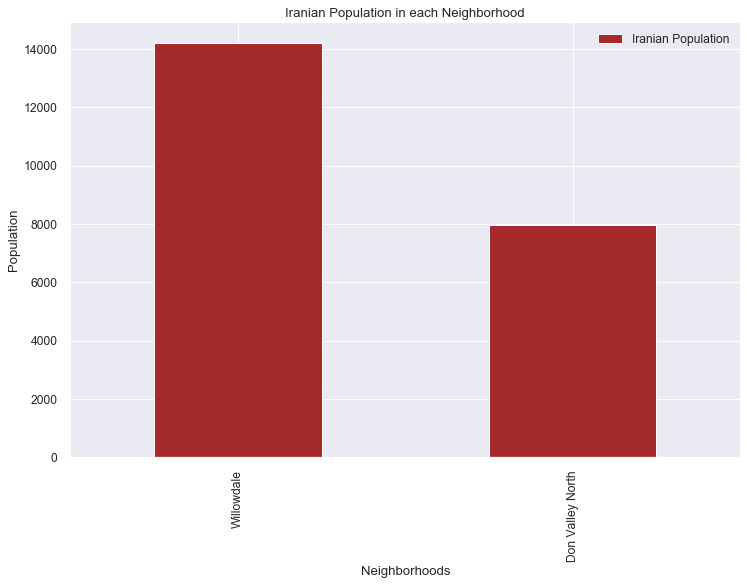

In [36]:
bar_graph = pop_persian_DF_with_percent.sort_values(by='Iranian Population', ascending=False)
bar_graph.plot(kind='bar',x='Riding', y='Iranian Population',figsize=(12,8), color='brown')
plt.title("Iranian Population in each Neighborhood")
plt.xlabel("Neighborhoods")
plt.ylabel("Population")
plt.show()

This analysis & visualization of the relationship between neighborhoods & Persian population present in those neighborhoods helps us in identifying the highly populated persian neighborhoods. Once we identify those neighborhoods it helps us in deciding where to place the new Persian restaurant. Persian restaurant placed in an densely populated Persian neighborhood is more likely to get more Persian customers than a restaurant placed in a neighborhood with less or no Persian population. Thus this analysis helps in the determining the success of the new Persian restaurant. 

<h3>Relationship between Indian poplation and Persian restaurant </h3>

First get the list of neighborhoods present in the riding using the wikipedia geography section for each riding. Altering the riding names to match the wikipedia page so we can retrieve the neighborhoods present in those ridings

In [37]:
#Altering the list to match the wikipedia page so we can retrieve the neighborhoods present in those Ridings
riding_list = pop_persian_DF_with_percent['Riding'].to_list()
riding_list[riding_list.index('Willowdale')] = 'Willowdale (electoral district)'
riding_list[riding_list.index('Don Valley North')] = 'Don Valley North'
riding_list

['Willowdale (electoral district)', 'Don Valley North']

In [38]:
#Scraping wiki page to get the neighborhoods of ech Ridings
import wikipedia

Riding_neighborhood_df = pd.DataFrame()

for item in riding_list:
    section = wikipedia.WikipediaPage(item).section('Geography')
    start = section.index('neighbourhoods of') + 17
    stop = section.index('.',start)
    Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding':item, 'Neighborhoods':section[start:stop]},ignore_index=True)
    

Riding_neighborhood_df = Riding_neighborhood_df[['Riding','Neighborhoods']]
Riding_neighborhood_df
    

,Riding,Neighborhoods
0,Willowdale (electoral district),"Willowdale, Lansing, Newtonbrook and North Yo..."
1,Don Valley North,"Henry Farm, Bayview Village, Bayview Woods-St..."


In [39]:
#Merging the pop_indian_DF_with_percent dataframe containing population information with the Riding_neighborhood_df dataframe.

Neigh_pop = pd.merge(pop_persian_DF_with_percent, Riding_neighborhood_df, on='Riding')

Neigh_pop.drop(columns=['Riding'],inplace =True)
Neigh_pop



,Iranian Population,Neighborhoods
0,7961.38,"Henry Farm, Bayview Village, Bayview Woods-St..."


In [40]:
Neigh_pop['split_neighborhoods'] = Neigh_pop['Neighborhoods'].str.split(',') 
Neigh_pop.drop(columns=['Neighborhoods'],inplace=True,axis=1)
Neigh_pop = Neigh_pop.split_neighborhoods.apply(pd.Series).merge(Neigh_pop, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['Iranian Population'], value_name = "Neighborhoods").drop("variable", axis = 1).dropna()

Neigh_pop.reset_index()
Neigh_pop

,Iranian Population,Neighborhoods
0,7961.38,Henry Farm
1,7961.38,Bayview Village
2,7961.38,Bayview Woods-Steeles
3,7961.38,Hillcrest Village
4,7961.38,Don Valley Village
5,7961.38,and Pleasant View


In [41]:
toronto_part['split_neighborhoods'] = toronto_part['Neighborhood'].str.split(',') 
toronto_part.drop(columns=['Neighborhood'],inplace=True,axis=1)
toronto_part = toronto_part.split_neighborhoods.apply(pd.Series).merge(toronto_part, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['Persian Restaurant'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()

toronto_part.reset_index()
toronto_part.rename(columns={'Neighborhood':'Neighborhoods'}, inplace=True)
toronto_part.sort_values('Persian Restaurant', ascending= False, inplace=True)
toronto_part.head(15)

,Persian Restaurant,Neighborhoods
30,0.020833,Forest Hill North & West
238,0.010000,Grange Park
182,0.010000,Harbord
44,0.010000,Kensington Market
85,0.010000,University of Toronto
141,0.010000,Chinatown
0,0.000000,Agincourt
157,0.000000,Roncesvalles
158,0.000000,Woodbine Gardens
160,0.000000,Ontario Provincial Government


In [42]:
pop_merged_restaurant_percent = pd.merge(Neigh_pop, toronto_part, on='Neighborhoods')
pop_merged_restaurant_percent

,Iranian Population,Neighborhoods,Persian Restaurant


After performing the data cleaning & data analysis we can identify that their no big relationship established in terms of the Persian population & the popular Persian restaurants. 

Thus this marks end of the data cleaning & analyses step in this project. Next we will look into the predictive modeling. In the predictive modelling we are going to use Clustering techniques since this is analysis of unlabelled data. K-Means clustering is used to perform the analysis of the data at hand. 

<h2>Predictive Modeling</h2>

<h3>Clustering Neighborhoods of Toronto:</h3>

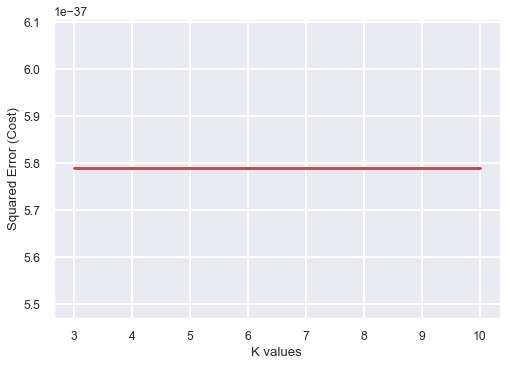

In [43]:
from sklearn.cluster import KMeans

toronto_part_clustering = toronto_part.drop('Neighborhoods', 1)


error_cost = []

for i in range(3,11):
    KM = KMeans(n_clusters = i, max_iter = 100)
    try:
        KM.fit(toronto_part_clustering)
    except ValueError:
        print("error on line",i)
    
    
    
    
    #calculate squared error for the clustered points
    error_cost.append(KM.inertia_/100)

#plot the K values aganist the squared error cost
plt.plot(range(3,11), error_cost, color='r', linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)
plt.show()

In [44]:
#!conda install -c districtdatalabs yellowbrick

from yellowbrick.cluster import KElbowVisualizer

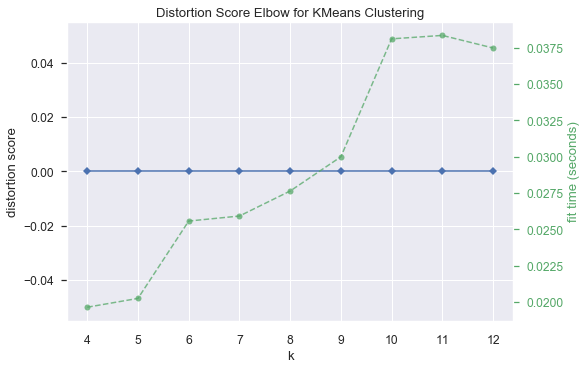

In [45]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,13))

visualizer.fit(toronto_part_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

<h4> Clustering the Toronto Neighborhood Using K-Means with K = 6 </h4>

In [46]:
kclusters = 6

toronto_part_clustering = toronto_part.drop('Neighborhoods', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_part_clustering)

kmeans.labels_

array([2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0], dtype=int32)

In [48]:
#toronto_part.drop(['Cluster Labels'],axis=1,inplace=True)
toronto_part.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = toronto_DF
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_part.set_index('Neighborhoods'), on='Neighborhood')
toronto_merged.dropna(subset=["Cluster Labels"], axis=0, inplace=True)
toronto_merged.reset_index(drop=True, inplace=True)
toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head()

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Persian Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.0,0.0
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.0,0.0
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678,0.0,0.0
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,0.0,0.0
4,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.0,0.0


In [49]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, width='90%', height='70%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

We have total of 6 clusters such as 0,1,2,3,4,5. Let us examine one after the other.

Cluster 0 contains all the neighborhoods which has least number of Persian restaurants. It is shown in red color in the map


In [50]:
#Cluster 0
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Persian Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.0,0.0
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.0,0.0
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678,0.0,0.0
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,0.0,0.0
4,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.0,0.0
6,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529,0.0,0.0
7,Downtown Toronto,M4Y,Church and Wellesley,43.665860,-79.383160,0.0,0.0
8,Downtown Toronto,M5C,St. James Town,43.651494,-79.375418,0.0,0.0
9,Downtown Toronto,M5C,St. James Town,43.651494,-79.375418,0.0,0.0
10,Downtown Toronto,M5E,Berczy Park,43.644771,-79.373306,0.0,0.0


Cluster 1 has no rows meaning no data points or neighborhood was near to this centroid.

In [51]:
#Cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Persian Restaurant



Cluster 2 contains the neighborhoods which is sparsely populated with Persian restaurants. It is shown in purple color in the map.

In [52]:
#Cluster 2
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]


,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Persian Restaurant
5,Central Toronto,M5P,Forest Hill North & West,43.696948,-79.411307,2.0,0.020833


Cluster 3 has no rows meaning no data points or neighborhood was near to this centroid.

In [53]:
#Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Persian Restaurant


Cluster 4 has no rows meaning no data points or neighborhood was near to this centroid. 

In [54]:
#Cluster 4
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Persian Restaurant


Cluster 5 has no rows meaning no data points or neighborhood was near to this centroid.

In [55]:
#Cluster 5
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5]

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Persian Restaurant


<h2>Results and Discussion:</h2>

<h3>Results</h3>

We have reached the end of the analysis; in this section we will document all the findings from above clustering & visualization of the dataset. In this project, we started off with the business problem of identifying a good neighbourhood to open a new Persian restaurant. To achieve that we looked into all the neighbourhoods in Toronto, analysed the Persian population in each neighbourhood & number of Persian restaurants in those neighbourhoods to come to conclusion about which neighbourhood would be a better spot. We have used variety of data sources to set up a very realistic data-analysis scenario. \
We have found out that: \
• In those 11 boroughs we identified that only Central Toronto, Downtown Toronto, North York have high number of Persian restaurants with the help of Violin plots between Number of Persian restaurants in Borough of Toronto. \
• In all the ridings, Willowdale, Don Valley North are the densely populated with Persian crowd ridings. \
• With the help of clusters examining & violin plots looks like Downtown Toronto, Central Toronto, East York are already densely populated with Persian restaurants. So, it is better idea to leave those boroughs out and consider only, East Toronto & North York for the new restaurant’s location. \
• After careful consideration it is a good idea to open a new Persian restaurant in Willowdale since it has high number of Persian populations which gives a higher number of customers possibility and lower competition since very less Persian restaurants in the neighbourhoods. 


<h3>Discussion</h3>

According to this analysis, Willowdale borough will provide the least competition for the new upcoming Persian restaurant as there is very little Persian restaurants spread or no Persian restaurants in few neighbourhoods. Also looking at the population distribution looks like it is densely populated with Persian crowd which helps the new restaurant by providing high customer visit possibility. So, definitely this region could potentially be a perfect place for starting a quality Persian restaurant. \
Some of the drawbacks of this analysis are; \
the clustering is completely based only on data obtained from Foursquare API and the data about the Persian population distribution in each neighbourhood is also based on the 2016 census which is not up-to date. Thus, there is huge gap of 3 years in the population distribution data. Even Though there are lots of areas where it can be improved yet this analysis has certainly provided us with some good insights, preliminary information on possibilities & a head start into this business problem by setting the step stones properly

<h2>Conclusion</h2>

Finally, to conclude this project, we have got a chance to on a business problem like how a real like data scientists would do. We have used many python libraries to fetch the data, to manipulate the contents & to analyse and visualize those datasets. We have made use of Foursquare API to explore the venues in neighbourhoods of Toronto, then get good amount of data from Wikipedia which we scraped with help of Wikipedia python library and visualized using various plots present in seaborn & matplotlib. We also applied machine learning technique to predict the output given the data and used Folium to visualize it on a map. \
Some of the drawbacks or areas of improvements shows us that this analysis can be further improved with the help of more data and different machine learning technique. Similarly, we can use this project to analysis any scenario such as opening a different cuisine restaurant or opening of a new gym and etc. Hopefully, this project helps acts as initial guidance to take more complex real-life challenges using data-science